In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

# one hot encoder
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

from sklearn import preprocessing
labelencoder = preprocessing.LabelEncoder()

from pygam import LinearGAM, s, f, te

# ignore warning
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.filterwarnings('ignore')

# Merge 2 dataframe

In [10]:
# read  from csv file
QA_model_df = pd.read_csv("./regression_df_input/QA_model_df.csv")
MD_model_df = pd.read_csv("./regression_df_input/MD_model_df.csv")

# change sentiment&topic name 
df_MD_prefix = MD_model_df.copy()
df_MD_prefix['date'] = df_MD_prefix['date'].astype(str)
# ------> multiple the probability with WA_sentiment
for i in range (1,29):
    df_MD_prefix['MD_sentiment&topic_'+str(i)] = df_MD_prefix['topic_'+str(i)]*df_MD_prefix['WA_sentiment']

df_QA_prefix = QA_model_df.copy()
df_QA_prefix['date'] = df_QA_prefix['date'].astype(str)
# ------> multiple the probability with WA_sentiment
for i in range (1,28):
    df_QA_prefix['QA_sentiment&topic_'+str(i)] = df_QA_prefix['topic_'+str(i)]*df_QA_prefix['WA_sentiment']

# take only necessary columns
common_columns = df_MD_prefix.columns.tolist()[:5]
df_MD_prefix = df_MD_prefix.drop(['D-1','D-2','D-3','D-4',
                                  'D-5','D-6','D-7','D-8','D-9',
                                  'D-10','D-11','D-12','D-13','D-14','D-15'
                                  ], axis = 1)



MD_sent_tp_stock_prc = df_MD_prefix.columns.tolist()[-43:]
# MD_sent_tp_stock_prc
QA_sent_tp = df_QA_prefix.columns.tolist()[-27:]
# QA_sent_tp

df_MD = df_MD_prefix[common_columns+MD_sent_tp_stock_prc]
df_QA = df_QA_prefix[common_columns+QA_sent_tp]

# merge 2 df
df_regression = df_MD.merge(df_QA, how='inner', on=['company_name','Group','ticker','file_name','date'])
df_regression = df_regression.reset_index(drop=True)
df_regression.head(5)

,company_name,Group,ticker,file_name,date,D+1,D+2,D+3,D+4,D+5,...,QA_sentiment&topic_18,QA_sentiment&topic_19,QA_sentiment&topic_20,QA_sentiment&topic_21,QA_sentiment&topic_22,QA_sentiment&topic_23,QA_sentiment&topic_24,QA_sentiment&topic_25,QA_sentiment&topic_26,QA_sentiment&topic_27
0,Admiral Group,Motor/Personal,ADM.L,20110302_Admiral_Group_PLC-_Earnings_Call_2011...,2011-03-02,0.013897,0.015106,-0.000604,0.003625,-0.003021,...,0.000091,0.000065,0.000147,0.000085,0.000045,0.000558,0.000104,0.000297,0.000106,0.000398
1,Admiral Group,Motor/Personal,ADM.L,20110824_Admiral_Group_PLC-_Earnings_Call_2011...,2011-08-24,-0.054693,-0.025868,-0.005913,0.008869,0.011086,...,0.001536,0.000151,0.000346,0.000175,0.000077,0.000011,0.000347,0.000439,0.001214,0.000350
2,Admiral Group,Motor/Personal,ADM.L,20111109_Admiral_Group_PLC-_Guidance_Call_2011...,2011-11-09,-0.076056,-0.053521,-0.061972,-0.064789,-0.098028,...,0.000390,0.000278,0.000184,0.000172,0.000162,0.000168,0.000159,0.000600,0.000061,0.000278
3,Admiral Group,Motor/Personal,ADM.L,20120307_Admiral_Group_PLC-_Earnings_Call_2012...,2012-03-07,0.015734,0.012238,0.022727,0.035839,0.036713,...,0.000789,0.000445,0.000480,0.000505,0.000158,0.000963,0.000275,0.002285,0.000453,0.000655
4,Admiral Group,Motor/Personal,ADM.L,20120830_Admiral_Group_PLC-_Earnings_Call_2012...,2012-08-30,0.020654,-0.010327,-0.044750,-0.030981,-0.023236,...,-0.000729,-0.000293,-0.000027,-0.000215,-0.000087,-0.000381,-0.000133,-0.000780,-0.000110,-0.000148


# Regression find date

In [19]:
day_list = ['D+1','D+2','D+3','D+4',
            'D+5','D+6','D+7','D+8','D+9','D+10',
            # 'D+11','D+12','D+13','D+14','D+15'
            ]
X_col = df_regression.columns[20:]
X = df_regression[X_col]
X

,MD_sentiment&topic_1,MD_sentiment&topic_2,MD_sentiment&topic_3,MD_sentiment&topic_4,MD_sentiment&topic_5,MD_sentiment&topic_6,MD_sentiment&topic_7,MD_sentiment&topic_8,MD_sentiment&topic_9,MD_sentiment&topic_10,...,QA_sentiment&topic_18,QA_sentiment&topic_19,QA_sentiment&topic_20,QA_sentiment&topic_21,QA_sentiment&topic_22,QA_sentiment&topic_23,QA_sentiment&topic_24,QA_sentiment&topic_25,QA_sentiment&topic_26,QA_sentiment&topic_27
0,7.184233e-07,1.199604e-06,3.420231e-06,1.951577e-07,2.348199e-05,1.638127e-07,1.721696e-06,0.000018,1.427721e-07,0.000038,...,0.000091,0.000065,0.000147,0.000085,0.000045,0.000558,0.000104,0.000297,0.000106,0.000398
1,1.896626e-06,3.773778e-06,1.327731e-06,5.374828e-05,1.540129e-05,9.033307e-06,5.942821e-05,0.000014,1.856324e-06,0.000085,...,0.001536,0.000151,0.000346,0.000175,0.000077,0.000011,0.000347,0.000439,0.001214,0.000350
2,-2.903839e-05,-4.336764e-07,-5.304375e-07,-1.116567e-05,-4.830904e-07,-3.654281e-07,-1.561813e-07,-0.000076,-3.184915e-07,-0.000101,...,0.000390,0.000278,0.000184,0.000172,0.000162,0.000168,0.000159,0.000600,0.000061,0.000278
3,3.049054e-06,4.730480e-06,1.452081e-06,2.287521e-05,1.322467e-06,1.000365e-06,9.866463e-06,0.000070,8.718751e-07,0.000186,...,0.000789,0.000445,0.000480,0.000505,0.000158,0.000963,0.000275,0.002285,0.000453,0.000655
4,2.874455e-06,7.402085e-06,7.483482e-07,2.949090e-06,8.642737e-06,8.476738e-06,2.203427e-07,0.000016,4.493319e-07,0.000110,...,-0.000729,-0.000293,-0.000027,-0.000215,-0.000087,-0.000381,-0.000133,-0.000780,-0.000110,-0.000148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1642,7.685635e-04,3.053869e-05,7.751519e-05,1.511122e-04,1.480031e-04,9.235486e-05,2.337426e-06,0.000002,3.639617e-05,0.000003,...,0.000980,0.000124,0.000019,0.000368,0.000246,0.000118,0.000038,0.000110,0.001170,0.000442
1643,1.397907e-03,8.912917e-06,6.102553e-04,1.322073e-04,9.928473e-06,7.510278e-06,3.402483e-05,0.000008,1.007125e-04,0.000168,...,0.002074,0.000118,0.000174,0.000951,0.001062,0.000460,0.000078,0.001581,0.000171,0.000172
1644,1.071591e-03,2.334700e-05,5.900620e-06,2.394854e-05,3.202607e-04,2.078153e-04,2.026012e-05,0.000004,2.946095e-05,0.000081,...,0.001780,0.000370,0.000068,0.000394,0.000108,0.000543,0.000122,0.000236,0.000226,0.000283
1645,1.065442e-03,1.370155e-04,4.355305e-04,5.388094e-05,4.244722e-04,3.598659e-06,1.856420e-05,0.000020,2.312746e-05,0.000104,...,0.001369,0.000355,0.000079,0.001265,0.000658,0.000549,0.000650,0.001085,0.000458,0.001140


In [20]:
for day in day_list:
    print(f"================== {day} ==================")
    df_run = df_regression[df_regression[day]<0]

    X = df_run[X_col].values.tolist()
    Y = df_run[day]

    gam = LinearGAM(s(0)+ s(1)+ s(2)+ s(3)+ s(4)+ s(5)+ s(6)+ s(7)+ s(8)+ s(9)+ s(10)+ s(11)+ s(12)+ s(13)+ s(14)+ s(15)+ s(16)+ 
                    s(17)+ s(18)+ s(19)+ s(20)+ s(21)+ s(22)+ s(23)+ s(24)+ s(25)+ s(26)+ s(27)+ s(28)+ s(29)+ s(30)+ s(31)+ 
                    s(32)+ s(33)+ s(34)+ s(35)+ s(36)+ s(37)+ s(38)+ s(39)+ s(40)+ s(41)+ s(42)+ s(43)+ s(44)+ s(45)+ s(46)+ 
                    s(47)+ s(48)+ s(49)+ s(50)+ s(51)+ s(52)+ s(53)+ s(54)).fit(X, Y)

    print(gam.summary())
    print("                      ")

================== D+1 ==================
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    213.1493
Link Function:                     IdentityLink Log Likelihood:                               -998178.1919
Number of Samples:                          777 AIC:                                          1996784.6825
                                                AICc:                                         1996948.6908
                                                GCV:                                                0.0005
                                                Scale:                                              0.0003
                                                Pseudo R-Squared:                                   0.

In [67]:
day = 'D+2'

df_run = df_regression[df_regression[day]<0]

X = df_run[X_col].values.tolist()
Y = df_run[day]

gam = LinearGAM(s(0)+ s(1)+ s(2)+ s(3)+ s(4)+ s(5)+ s(6)+ s(7)+ s(8)+ s(9)+ s(10)+ s(11)+ s(12)+ s(13)+ s(14)+ s(15)+ s(16)+ 
                    s(17)+ s(18)+ s(19)+ s(20)+ s(21)+ s(22)+ s(23)+ s(24)+ s(25)+ s(26)+ s(27)+ s(28)+ s(29)+ s(30)+ s(31)+ 
                    s(32)+ s(33)+ s(34)+ s(35)+ s(36)+ s(37)+ s(38)+ s(39)+ s(40)+ s(41)+ s(42)+ s(43)+ s(44)+ s(45)+ s(46)+ 
                    s(47)+ s(48)+ s(49)+ s(50)+ s(51)+ s(52)+ s(53)+ s(54)).fit(X, Y)

print(gam.summary())                  

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    209.6769
Link Function:                     IdentityLink Log Likelihood:                               -654015.3401
Number of Samples:                          761 AIC:                                           1308452.034
                                                AICc:                                          1308614.399
                                                GCV:                                                0.0008
                                                Scale:                                              0.0004
                                                Pseudo R-Squared:                                      0.4
Feature Function                  Lam

<Figure size 432x288 with 0 Axes>

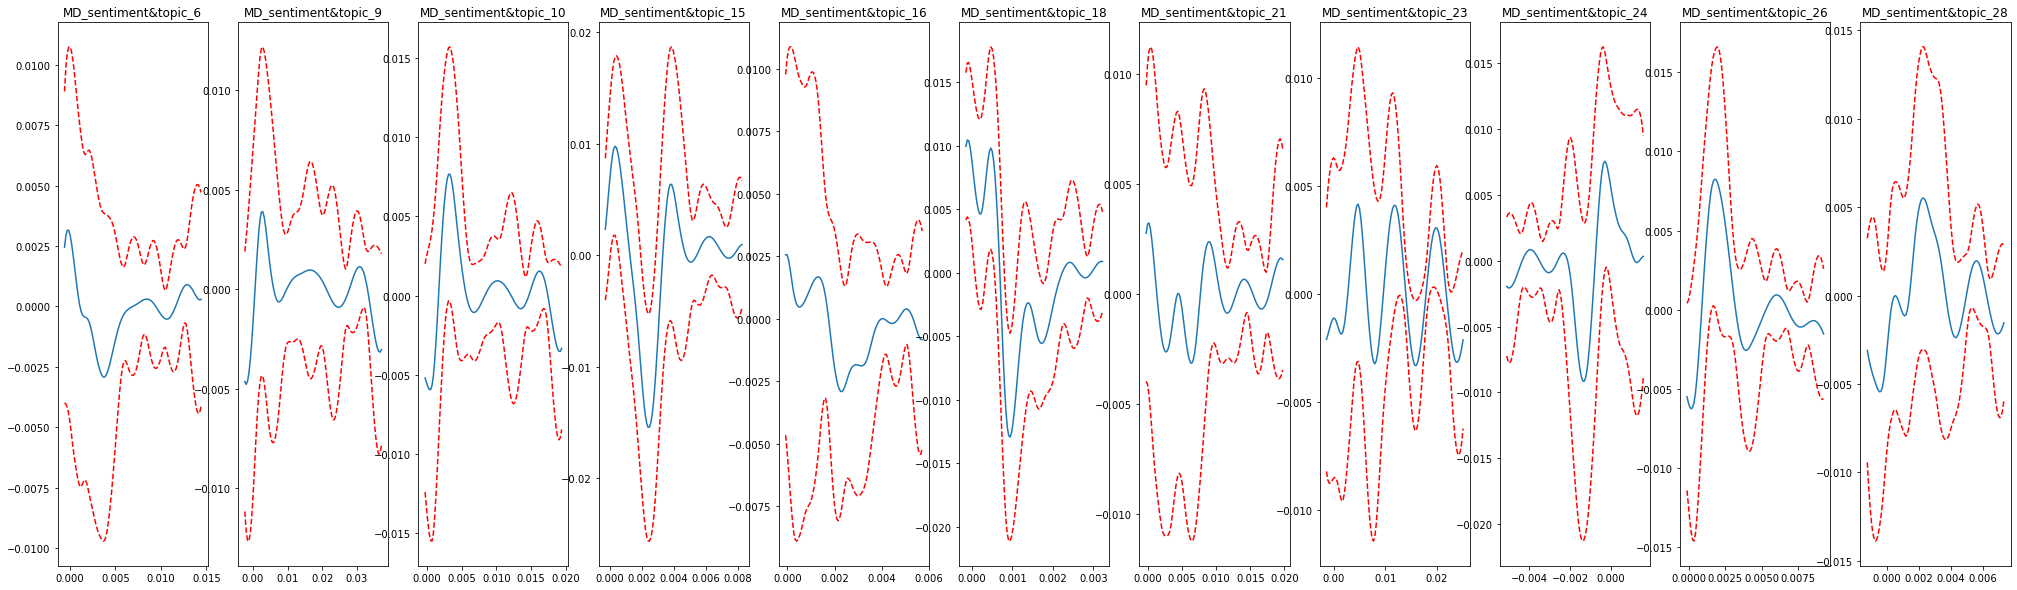

In [69]:
## plotting
plt.figure()
fig, axs = plt.subplots(1,11, figsize=(35,10))


titles = ['MD_sentiment&topic_6','MD_sentiment&topic_9','MD_sentiment&topic_10','MD_sentiment&topic_15','MD_sentiment&topic_16',
            'MD_sentiment&topic_18', 'MD_sentiment&topic_21', 'MD_sentiment&topic_23','MD_sentiment&topic_24','MD_sentiment&topic_26',
            'MD_sentiment&topic_28'
]
significant_list = [ 5,8,9,14,15,17,20,22,23,25,27 ]

for i, ax in enumerate(axs):
    for id, val in enumerate(significant_list):
        if i == id:
            XX = gam.generate_X_grid(term=val)
            ax.plot(XX[:, val], gam.partial_dependence(term=val, X=XX))
            ax.plot(XX[:, val], gam.partial_dependence(term=val, X=XX, width=.95)[1], c='r', ls='--')
            ax.set_title(titles[id])

<Figure size 432x288 with 0 Axes>

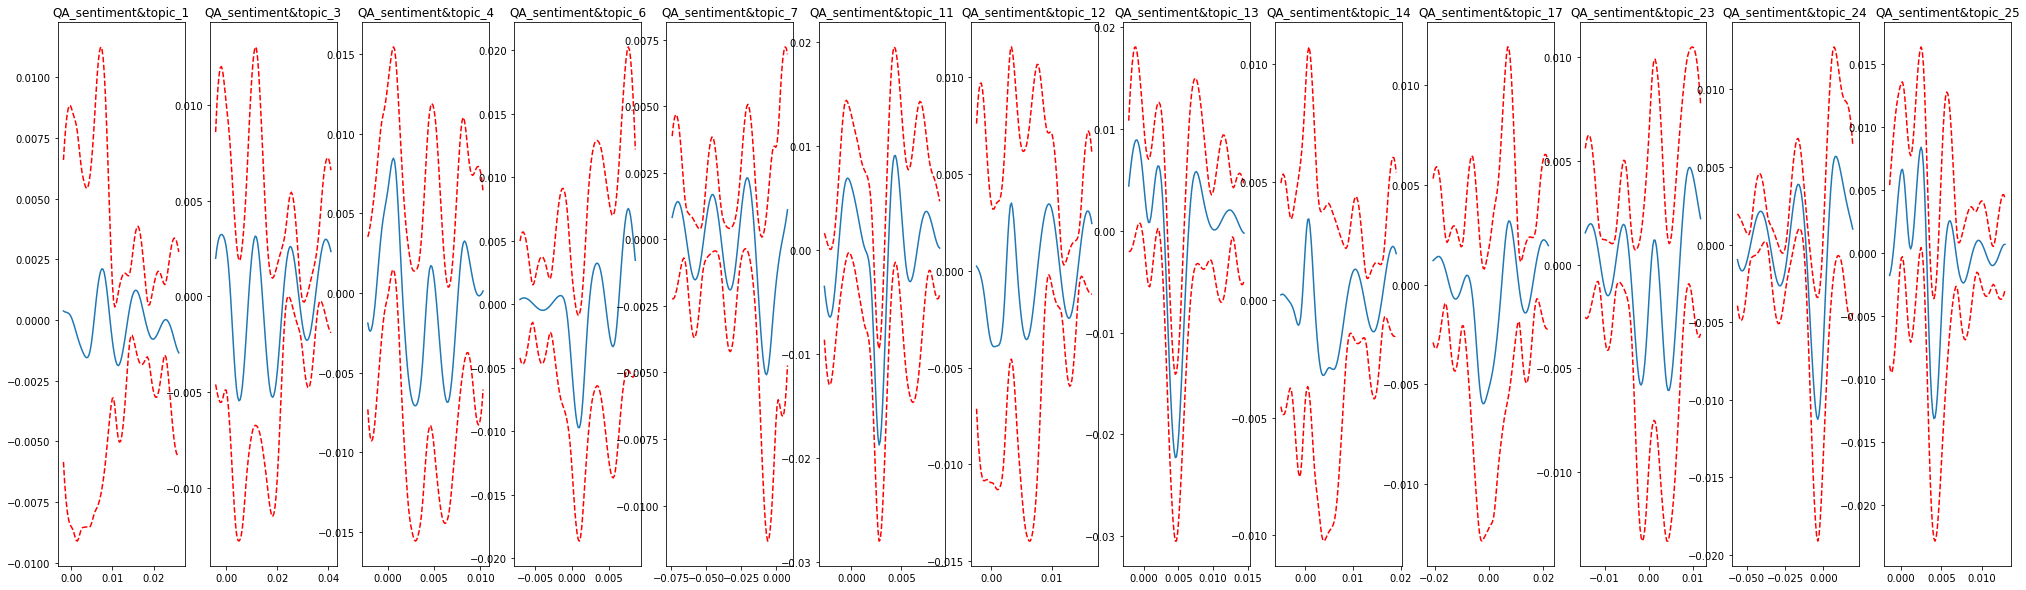

In [71]:
## plotting
plt.figure()
fig, axs = plt.subplots(1,13, figsize=(35,10))

titles = ['QA_sentiment&topic_1','QA_sentiment&topic_3','QA_sentiment&topic_4','QA_sentiment&topic_6','QA_sentiment&topic_7',
            'QA_sentiment&topic_11','QA_sentiment&topic_12','QA_sentiment&topic_13','QA_sentiment&topic_14','QA_sentiment&topic_17',
            'QA_sentiment&topic_23','QA_sentiment&topic_24','QA_sentiment&topic_25'
]
significant_list = [28,30,31,33,34,38,39,40,41,44,50,51,52]

for i, ax in enumerate(axs):
    for id, val in enumerate(significant_list):
        if i == id:
            XX = gam.generate_X_grid(term=val)
            ax.plot(XX[:, val], gam.partial_dependence(term=val, X=XX))
            ax.plot(XX[:, val], gam.partial_dependence(term=val, X=XX, width=.95)[1], c='r', ls='--')
            ax.set_title(titles[id])

# Draft

In [61]:
# form = 's(0)'
# for i in range(1,55):
#     name = f'+ s({i})'
#     form += name
# form

's(0)+ s(1)+ s(2)+ s(3)+ s(4)+ s(5)+ s(6)+ s(7)+ s(8)+ s(9)+ s(10)+ s(11)+ s(12)+ s(13)+ s(14)+ s(15)+ s(16)+ s(17)+ s(18)+ s(19)+ s(20)+ s(21)+ s(22)+ s(23)+ s(24)+ s(25)+ s(26)+ s(27)+ s(28)+ s(29)+ s(30)+ s(31)+ s(32)+ s(33)+ s(34)+ s(35)+ s(36)+ s(37)+ s(38)+ s(39)+ s(40)+ s(41)+ s(42)+ s(43)+ s(44)+ s(45)+ s(46)+ s(47)+ s(48)+ s(49)+ s(50)+ s(51)+ s(52)+ s(53)+ s(54)'